# Comparative Monte Carlo

This script shows how to perform a more advanced comparative Monte Carlo simulation.

We also run Monte Carlo simulation using the background system and not only the foreground one as in the previous notebook.

A comparative Monte Carlo is the type of simulation to be used in comparative LCAs, i.e. in analyses where different alternatives to provide the same Functional Unit are compared. In this comparative case it is important to randomly sample a common technology matrix **A** for all alternatives at each iteration, instead of having a different technology matrix per each alternative at each iteration. This allows for a smaller variance and shorter computational times, but is not possible with e.g. SimaPro. Moreover, this allows to optimally perform the  statistical testing of the results with paired tests, to see if the two alternatives are significantly different from each other or not. 

To better understand this script, I recommend reading read the paper by Henriksson et al. (2015) which is probably the best example of an LCA with comparative Monte Carlo simulation followed by statistical testing for significant differences between alternatives. 

_Henriksson, P. J. G., Rico, A., Zhang, W., Ahmad-Al-Nahid, S., Newton, R., Phan, L. T., … Guinée, J. B. (2015). Comparison of Asian Aquaculture Products by Use of Statistically Supported Life Cycle Assessment. Environmental Science and Technology, 49(24), 14176-14183. [https://doi.org/10.1021/acs.est.5b04634](https://doi.org/10.1021/acs.est.5b04634)_

In [1]:
# Import brightway2.5 packages
import bw2calc as bc
import bw2data as bd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
bd.projects.set_current('advlca23')
bd.databases

Databases dictionary with 4 object(s):
	biosphere3
	ecoinvent 3.9.1 conseq
	exldb
	testdb

In [3]:
db = bd.Database("ecoinvent 3.9.1 conseq")
ipcc = ('IPCC 2013', 'climate change', 'global warming potential (GWP100)')

In [4]:
# Simple LCA on ecoinvent process as we know it. We are using the background system.
random_process = db.random() # select a random process
mydemand = {random_process: 1}
lca = bc.LCA(mydemand, ipcc)
lca.lci()
lca.lcia()
lca.score

0.9202963820176275

In [5]:
# We don't need to add uncertainty here, because ecoinvent process include uncertainty on some exchanges.
for exchange in random_process.exchanges():
    print(exchange["uncertainty type"], end=" ")

0 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [6]:
# Monte Carlo simulation
mc = bc.LCA(demand=mydemand, method=ipcc, use_distributions=True)
mc.lci()
mc.lcia()
mc_results = [mc.score for _ in zip(range(100), mc)] # will take a minute, we are randomly sampling ecoinvent 100 times

0.9202963820176275

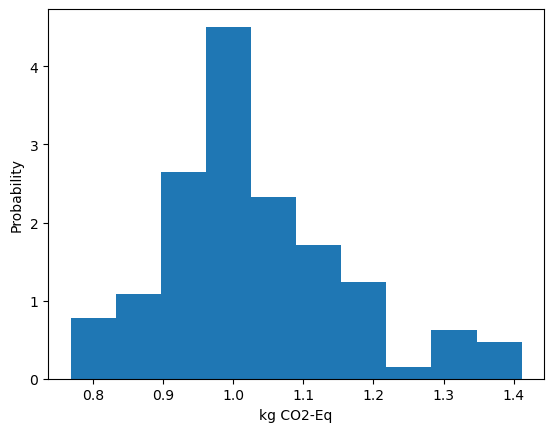

In [7]:
# plot MC results
plt.hist(mc_results, density=True)
plt.ylabel("Probability")
plt.xlabel(bd.methods[ipcc]["unit"])
pd.DataFrame(mc_results).describe() 
lca.score

In [8]:
# Now comparative analysis, select two different transport activities
activity_name = 'transport, freight, lorry >32 metric ton, EURO5'    
for activity in bd.Database("ecoinvent 3.9.1 conseq"):
    if activity['name'] == activity_name:
        truckE5 = bd.Database("ecoinvent 3.9.1 conseq").get(activity['code'])

activity_name = 'transport, freight, lorry >32 metric ton, EURO6'    
for activity in bd.Database("ecoinvent 3.9.1 conseq"):
    if activity['name'] == activity_name:
        truckE6 = bd.Database("ecoinvent 3.9.1 conseq").get(activity['code'])

In [9]:
# make a list with the alternatives
demands = [{truckE5: 1}, {truckE6: 1}]  # At home, check by using the same process (e.g. truckE5) two times.

# We are calculating the impact of transport with the EURO5 truck
mc = bc.LCA(demand=demands[0], method=ipcc, use_distributions=True)
mc.lci()
mc.lcia()
mc_results = [mc.score for _ in zip(range(1), mc)]
print(mc_results[0])

0.1413289452947761


In [10]:
# look at this first
demands = [{truckE5.id: 1}, {truckE6.id: 1}]
mc.redo_lcia(demands[0]) # EURO5 truck
print(mc.score)
mc.redo_lcia(demands[1]) # EURO6 truck. I am using the same technology matrix "A" as before to calcualte results
print(mc.score)
mc.redo_lcia(demands[0]) # EURO5 truck again. Same result. Note how "redo.lcia" allows doing dependent sampling
print(mc.score)

0.1413289452947761
0.1439722838049246
0.1413289452947761


In [11]:
# Now for several iterations
iterations = 100
simulations = [] # empty list that will contain the restuls of all iterations, for all alternatives

for _ in range(iterations):
    #print(_)
    next(mc)
    mcresults = []    # empty list that will contain results for one iteration, for two alteratives
    for i in demands:
        mc.redo_lcia(i)
        mcresults.append(mc.score)
    simulations.append(mcresults) # appends one list to another
    
    
df = pd.DataFrame(simulations, columns = ['truckE5','truckE6']) # df is for "dataframe"
#df.to_csv('ComparativeMCsimulation.csv') # to save it

In [12]:
df

,truckE5,truckE6
0,0.131178,0.105755
1,0.189234,0.137730
2,0.104192,0.122925
3,0.122389,0.088996
4,0.139789,0.124299
...,...,...
95,0.110521,0.111924
96,0.131582,0.143175
97,0.115769,0.144008
98,0.155295,0.147461


<Axes: >

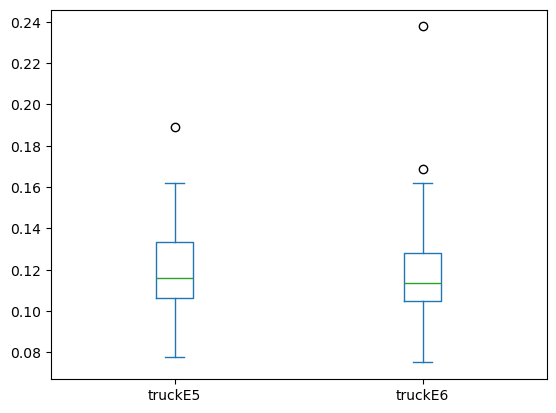

In [13]:
df.plot(kind = 'box')
#df.T.melt()

Text(0, 0.5, 'truckE6 - kg CO2-eq')

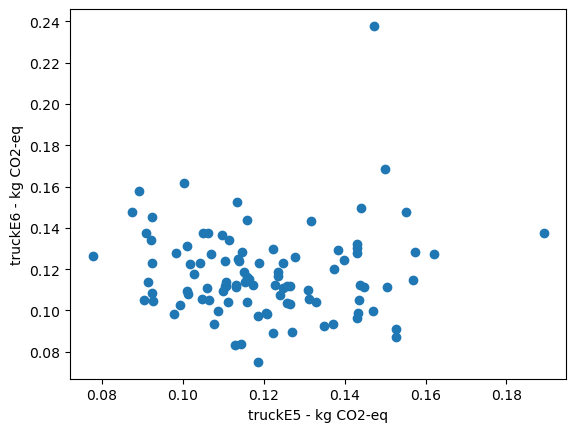

In [14]:
# plot one against the other to see if there is any trend
plt.plot(df.truckE5, df.truckE6, 'o')
plt.xlabel('truckE5 - kg CO2-eq')
plt.ylabel('truckE6 - kg CO2-eq')

45
55
0


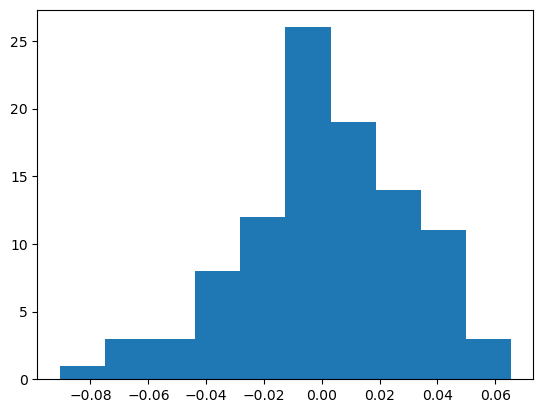

In [15]:
# You can see how many times the difference is positive. This is what Simapro does
df['diffe'] = df.truckE5 - df.truckE6
plt.hist(df.diffe.values)
print(len(df.diffe[df.diffe < 0]))
print(len(df.diffe[df.diffe > 0]))
print(len(df.diffe[df.diffe == 0]))

In [16]:
# Statistical testing (using the stats package)
# I can use a paired t-test

t_value, p_value = stats.ttest_rel(df.truckE5,df.truckE6)
t_value, p_value

(0.769476597568761, 0.44344248569811284)

0.04343924816594453
3.57581649415424e-07


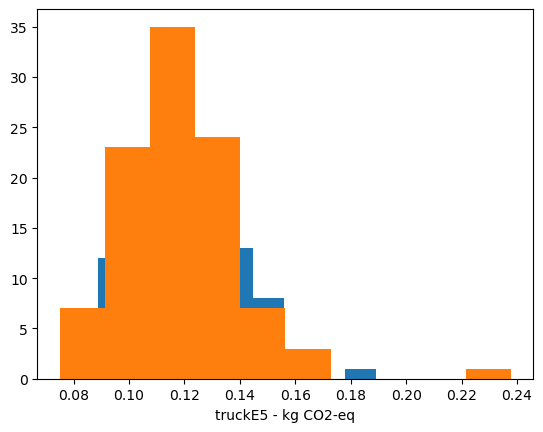

In [17]:
# But wait! did we check for normality?
plt.hist(df.truckE5.values)
plt.xlabel('truckE5 - kg CO2-eq')

SW_value, SW_p_value = stats.shapiro(df.truckE5)
print(SW_p_value) # Not normally distributed...

plt.hist(df.truckE6.values)
SW_value, SW_p_value = stats.shapiro(df.truckE6)
print(SW_p_value) # Not normally distributed...


In [18]:
# Alright need a non-parametric test. Wilcox sign rank test
s_value, p_value = stats.wilcoxon(df.truckE5, df.truckE6)
s_value, p_value # Not bad, significant difference at p < 0.01.

(2197.0, 0.259416834386872)

In [19]:
# What if we had done the MC on the processes independently.
# truckE5
mc1 = bc.LCA(demand={truckE5: 1}, method=ipcc, use_distributions=True)
mc1.lci()
mc1.lcia()
mc1_results = [mc.score for _ in zip(range(100), mc1)]

# it's still truckE5 !!! I am comparing two times the same activity
mc2 = bc.LCA(demand={truckE5: 1}, method=ipcc, use_distributions=True)
mc2.lci()
mc2.lcia()
mc2_results = [mc.score for _ in zip(range(100), mc2)]

df_ind = pd.DataFrame({'mc1': mc1_results, 'mc2' : mc2_results})

In [20]:
df_ind.head()

,mc1,mc2
0,0.16864,0.16864
1,0.16864,0.16864
2,0.16864,0.16864
3,0.16864,0.16864
4,0.16864,0.16864


In [21]:
# compare to this
demands = [{truckE5: 1}, {truckE5: 1}]  # Two times truckE5! I want to see if the MC results are paired

mc = bc.LCA(demand=demands[0], method=ipcc, use_distributions=True)
mc.lci()
mc.lcia()

simulations = []

demands = [{truckE5.id: 1}, {truckE5.id: 1}]  

for _ in  zip(range(100), mc):
    mc.score
    mcresults = []    
    for i in demands:
        mc.redo_lcia(i)
        mcresults.append(mc.score)
    simulations.append(mcresults)
    
    
simulations
df_dep = pd.DataFrame(simulations, columns = ['mc1','mc2'])

In [22]:
df_dep.head()

,mc1,mc2
0,0.106313,0.106313
1,0.141293,0.141293
2,0.136840,0.136840
3,0.152117,0.152117
4,0.118267,0.118267


<Axes: title={'center': 'dependent sampling'}>

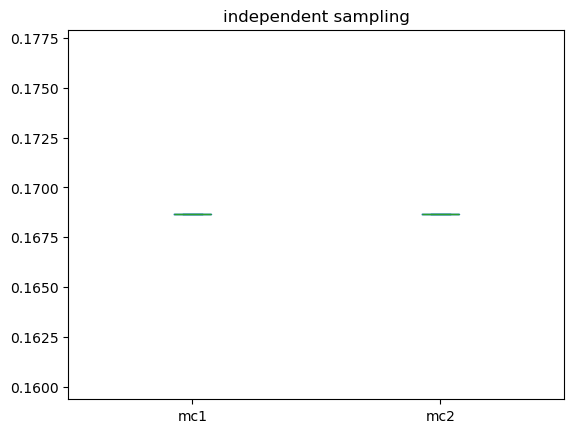

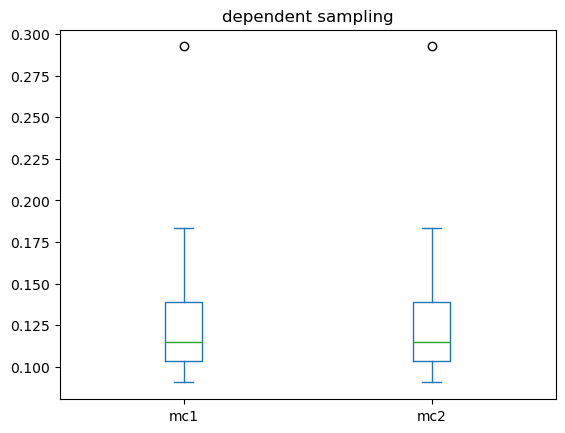

In [23]:
# visual inspection
df_ind.plot(kind = 'box', title = "independent sampling")
df_dep.plot(kind = 'box', title = "dependent sampling")

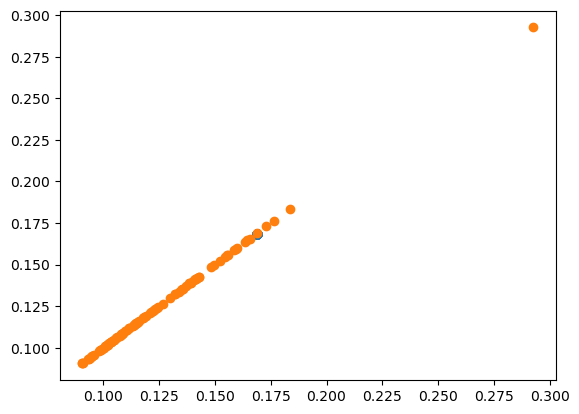

In [24]:
# Plot them together and one against the other
plt.plot(df_ind.mc1, df_ind.mc2, 'o')
plt.plot(df_dep.mc1, df_dep.mc2, 'o') # see?

In [25]:
# and of course:
t_value, p_value = stats.ttest_rel(df_dep.mc1, df_dep.mc2)
print(t_value, p_value)  # no difference AT ALL (as expected)

# t_value, p_value = stats.ttest_rel(df_ind.mc1, df_ind.mc2)
# print(t_value, p_value)  # no difference (as expected! But still some variance even if it's the same perocess!)

# s_value, p_value = stats.wilcoxon(df_ind.mc1, df_ind.mc2)
# print(s_value, p_value)


nan nan


# Additional resources to understand LCA statistics

When applying a statistical approach to LCA, there are some key concepts that is important to understand in detail: distribution types, error propagation, statistical testing. If you are new to statistics, a first step is reading the wikipedia pages explaining [Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method), general [statistical hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing), [parametric](https://en.wikipedia.org/wiki/Parametric_statistics) and [nonparametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) statistics, [normality tests](https://en.wikipedia.org/wiki/Normality_test), [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Alternatives_to_the_t-test_for_location_problems), [Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test). When implementing this in Brightway2, it is then useful to read the corresponding python documentation for [statistical functions](https://docs.scipy.org/doc/scipy/reference/stats.html) of the stats package. For example the following functions were used in this script: [Shapiro-Wilk test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro), [paired t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel), and [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon). 

If you want to learn more, buy a good introductory statistics book. Ideally one which has a good balance between mathematical expressions and pedagogic explanations. There are also many open source or free ones, I can recommend e.g. [Statistics](https://en.wikibooks.org/wiki/Statistics) which explains testing in general and it's written in a way which is easy to understand, [The Elements of Data Analytic Style](https://leanpub.com/datastyle) which introduces to data analysis in general, and [Statistical inference for data science](http://leanpub.com/LittleInferenceBook) which is is very practical and especially useful if you also know R. In general I would encourage to learn R too if you plan to work with stats - I honestly prefer it to python for doing statistical analysis and also for plots.



# Check also these
    
#### On Wikipedia

Monte Carlo method 
https://en.wikipedia.org/wiki/Monte_Carlo_method

Normal distribution
https://en.wikipedia.org/wiki/File:Standard_deviation_diagram.svg#/media/File:Standard_deviation_diagram.svg

Parameters of a logrormal distribution
https://en.wikipedia.org/wiki/Log-normal_distribution#/media/File:LogNormal17.jpg


#### On the Brightway website docs

Storing uncertain values
https://2.docs.brightway.dev/intro.html#storing-uncertain-values


#### Papers on this topic (recent ones)

A critique (not very clear tbh but still, a perspective) 
https://pub.epsilon.slu.se/19792/1/von_bromssen_c_et_al_201229.pdf

How many montecarlo runs? 
https://link.springer.com/article/10.1007/s11367-019-01698-4

Ways of doing comparative testing
https://link.springer.com/article/10.1007/s11367-020-01851-4
